# Core functions for Discrete Time Markov Chain Models

In [2]:
import pandas as pd
import numpy as np
from scipy import linalg as slin
from scipy import stats as stats
import warnings
warnings.filterwarnings('ignore')


In [148]:
obsfreq = np.array([
    [116, 15, 7, 7],
    [8, 25, 3, 11],
    [8, 4, 24, 4],
    [1, 2, 2, 13]
])
obsfreq
alpha = 0.05

### Test for Independence - First Order Markhov

In [149]:
def anderson_goodman_first_order_markov_chain(obsfreq):
    assert(type(obsfreq) == np.ndarray), "Object passed is not an Numpy Array."
    csum = obsfreq.sum(axis = 0)
    rsum = obsfreq.sum(axis = 1)

    total = csum.sum()

    observed = obsfreq.reshape(-1)

    expected = np.array([csum[j] * rsum[i] / total for i in range(csum.shape[0]) 
                         for j in range(rsum.shape[0])]).reshape(-1)

    data = pd.DataFrame({"observed": list(observed), "expected": list(expected)})
    data
    data['difference'] = (data["observed"] - data["expected"]) ** 2 / data["expected"]
    data

    chisq = data.difference.sum()
    chisq
    df = (rsum.shape[0] -1) * (csum.shape[0] - 1)
    df

    chicrit = stats.chi2.ppf(0.95, df)

    pval = 1 - stats.chi2.cdf(chisq, df)

    ho = "ho = Distributions are independent"
    ha = "ha = Distributions are dependent"

    print("Null Hypothesis :: {}".format(ho))
    print("Alternate Hypothesis :: {}".format(ha))
    print("\n")

    if pval < alpha:
        print("Chisq {} is more than critical Chisq value {} for significance alpha {} and df {}".format(
            chisq, chicrit, alpha, df))
        print("Corresponding p-value {} is below alpha / significance {} for df {} ".format(pval, alpha, df))
        print("Hence we reject the NULL Hypothesis, the distributions are dependent")
    else:
        print("Chisq {} is below critical Chisq value {} for significance alpha {} and df {}".format(chisq, chicrit, alpha, df))
        print("Corresponding p-value {} is more than alpha / significance {}".format(pval, alpha))
        print("Hence we retain the NULL Hypothesis")


In [150]:
anderson_goodman_first_order_markov_chain(obsfreq)

Null Hypothesis :: ho = Distributions are independent
Alternate Hypothesis :: ha = Distributions are dependent


Chisq 210.1368246033344 is more than critical Chisq value 16.918977604620448 for significance alpha 0.05 and df 9
Corresponding p-value 0.0 is below alpha / significance 0.05 for df 9 
Hence we reject the NULL Hypothesis, the distributions are dependent


### Test for Time Homogeneity

In [151]:
nt = np.array([
    [145, 47, 40, 18],
    [133, 46, 36, 35],
    [125, 57, 34, 34],
    #[116, 58, 38, 38],
    #[116, 58, 35, 41],
    #[109, 62, 37, 42]
])

F12 = np.array([
    [116, 15,7,7],
    [8,25,3,11],
    [8,4,24,4],
    [1,2,2,13]
])

F23 = np.array([
    [108, 13,7,5],
    [6,35,4,1],
    [8,4,21,3],
    [3,5,2,25]
])

nt

Freqlist = list([F12,F23])

 

In [152]:
def anderson_goodman_homogeniety_test_for_first_order_markov_chain(Freqlist):
    PTM12 = np.zeros(F12.shape)

    PTMlist = list([PTM12.copy(), PTM12.copy()]) ## Need to make this dynamic


    for x in np.arange(len(PTMlist)):
        for i in np.arange(nt.shape[1]):
            PTMlist[x][i,:] = Freqlist[x][i,:] / nt[x,i]

    PTMlist 

    totalElements = nt[:-1,:].sum(axis = 0).reshape(4,1)

    intermediate = np.zeros(F12.shape)
    for i in Freqlist:
        intermediate += i

    PTMA = intermediate / totalElements

    results = []

    for t in np.arange(nt.shape[0] - 1):
        for i in np.arange(PTMA.shape[0]):
            for j in np.arange(PTMA.shape[0]):
                results.append(nt[t,i] * (PTMlist[t][i, j] - PTMA[i,j]) ** 2)

    ho = "ho = PTMx elements == PTMAggregate elements"
    ha = "ha = PTMx elements != PTMAggregate elements"

    print("Null Hypothesis :: {}".format(ho))
    print("Alternate Hypothesis :: {}".format(ha))
    print("\n")

    chisq = sum(results)

    df = (len(Freqlist) - 1) * (PTMA.shape[0]) * (PTMA.shape[0] - 1)
    #print(df)

    chicrit = stats.chi2.ppf(0.95, df)
    pval = 1 - stats.chi2.cdf(chisq, df)

    if pval < alpha:
        print("Chisq {} is more than critical Chisq value {} for significance alpha {} and df {}".format(
            chisq, chicrit, alpha, df))
        print("Corresponding p-value {} is below alpha / significance {}".format(pval, alpha))
        print("Hence we reject the NULL Hypothesis, the distributions are dependent")
    else:
        print("Chisq {} is below critical Chisq value {} for significance alpha {} and df {}".format(chisq, chicrit, alpha, df))
        print("Corresponding p-value {} is more than alpha / significance {}".format(pval, alpha))
        print("Hence we retain the NULL Hypothesis")


In [153]:
anderson_goodman_homogeniety_test_for_first_order_markov_chain(Freqlist)

Null Hypothesis :: ho = PTMx elements == PTMAggregate elements
Alternate Hypothesis :: ha = PTMx elements != PTMAggregate elements


Chisq 2.4175787362249097 is below critical Chisq value 21.02606981748307 for significance alpha 0.05 and df 12
Corresponding p-value 0.9984441117674245 is more than alpha / significance 0.05
Hence we retain the NULL Hypothesis


# Steady State Probabilities

In [3]:
PTM = np.array([
    [.799, .201, 0,0,0],
    [.198, .276, .526, 0,0],
    [.178, .203,.065, .554,0],
    [.151, .159,.053,.029,.608],
    [.097, 0,0,0,0.903]
])
PTM

array([[0.799, 0.201, 0.   , 0.   , 0.   ],
       [0.198, 0.276, 0.526, 0.   , 0.   ],
       [0.178, 0.203, 0.065, 0.554, 0.   ],
       [0.151, 0.159, 0.053, 0.029, 0.608],
       [0.097, 0.   , 0.   , 0.   , 0.903]])

In [4]:
def get_Steady_State_Probability(PTM):
    assert(type(PTM) == np.ndarray), "Object passed is not an Numpy Array."
    PP1 = PTM.T * -1 + np.identity(PTM.shape[0])
    # last eqn omit
    #PP1 = PP1[:-1,:]
    PP1[PTM.shape[0]-1,:] = np.ones(PTM.shape[0])
    x1 = np.zeros(PTM.shape[0])
    x1[-1] = 1
    return slin.solve(PP1, np.array(x1).reshape(-1,1))

In [5]:
get_Steady_State_Probability(PTM)

array([[0.40809606],
       [0.14826655],
       [0.08619757],
       [0.04917966],
       [0.30826016]])

# State / revenue after N Periods -- NEED to change

In [187]:
periods = 5
C1 = np.array([639104, 194856, 76288, 31449, 58303]).reshape(1,5)
PTM = np.array([
    [.799, .201, 0,0,0],
    [.198, .276, .526, 0,0],
    [.178, .203,.065, .554,0],
    [.151, .159,.053,.029,.608],
    [.097, 0,0,0,0.903]
])

In [199]:
from numpy.linalg import matrix_power

def get_state_after_n_periods(PTM, periods, initital_state, revenue = None):
    assert(type(PTM) == np.ndarray), "Object passed is not an Numpy Array."    
    P1 = PTM.copy()
    #for i in np.arange(periods -1):
    #    P1 = P1.dot(PTM)
    P1 = matrix_power(P1, periods)
    if revenue is None:
        return (P1, initital_state.dot(P1))
    else:
        return (P1, initital_state.dot(P1).dot(revenue))

In [201]:
get_state_after_n_periods(PTM, 96, C1, revenue = [10,15,7,2,.1])

(array([[0.40809606, 0.14826655, 0.08619757, 0.04917966, 0.30826015],
        [0.40809606, 0.14826655, 0.08619757, 0.04917966, 0.30826016],
        [0.40809606, 0.14826655, 0.08619757, 0.04917966, 0.30826016],
        [0.40809606, 0.14826655, 0.08619757, 0.04917966, 0.30826016],
        [0.40809606, 0.14826655, 0.08619757, 0.04917966, 0.30826016]]),
 array([7037527.19144934]))

# Markov with Absorbing States

In [160]:
P1 = np.array(
    [   
        [0.511,0.489,0,0,0,0,0,0,0,0,0,0,0],
        [0.365,0,0.635,0,0,0,0,0,0,0,0,0,0],
        [0.3,0,0,0.7,0,0,0,0,0,0,0,0,0],
        [0.244,0,0,0,0.756,0,0,0,0,0,0,0,0],
        [0.205,0,0,0,0,0.795,0,0,0,0,0,0,0],
        [0.18,0,0,0,0,0,0.82,0,0,0,0,0,0],
        [0.153,0,0,0,0,0,0,0.847,0,0,0,0,0],
        [0.137,0,0,0,0,0,0,0,0.863,0,0,0,0],
        [0.105,0,0,0,0,0,0,0,0,0.895,0,0,0],
        [0.103,0,0,0,0,0,0,0,0,0,0.897,0,0],
        [0.091,0,0,0,0,0,0,0,0,0,0,0.909,0],
        [0.079,0,0,0,0,0,0,0,0,0,0,0,0.921],
        [0,0,0,0,0,0,0,0,0,0,0,0,1]
    ]
)
P1

array([[0.511, 0.489, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   ],
       [0.365, 0.   , 0.635, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   ],
       [0.3  , 0.   , 0.   , 0.7  , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   ],
       [0.244, 0.   , 0.   , 0.   , 0.756, 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   ],
       [0.205, 0.   , 0.   , 0.   , 0.   , 0.795, 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   ],
       [0.18 , 0.   , 0.   , 0.   , 0.   , 0.   , 0.82 , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   ],
       [0.153, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.847, 0.   ,
        0.   , 0.   , 0.   , 0.   ],
       [0.137, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.863,
        0.   , 0.   , 0.   , 0.   ],
       [0.105, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.895, 0.   , 0.   , 0.   ],
       [0.103, 0.   , 0.   ,

In [161]:
def get_Absorbing_State_Markov_data(PTM):
    assert(type(PTM) == np.ndarray), "Object passed is not an Numpy Array."    
    index = np.array(np.where(P1[:,:] == 1)).T
    index[:, 0]
    listRows = np.array(list(set(np.arange(P1.shape[0])) - set(index[:,0]))).reshape(-1,1)
    listCols = np.array(list(set(np.arange(P1.shape[0])) - set(index[:,1])))
    Q = P1[listRows, listCols]
    F = slin.inv(np.identity(Q.shape[0]) - Q)
    listCols = np.array(list(set(index[:,1])))
    R = P1[listRows, listCols]
    FR = slin.inv(np.identity(12) - Q).dot(R)
    time2churn = slin.inv(np.identity(12) - Q).sum(axis=1).reshape(-1,1)
    return Q, R, F, FR, time2churn

In [162]:
get_Absorbing_State_Markov_data(P1)

(array([[0.511, 0.489, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   ],
        [0.365, 0.   , 0.635, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   ],
        [0.3  , 0.   , 0.   , 0.7  , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   ],
        [0.244, 0.   , 0.   , 0.   , 0.756, 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   ],
        [0.205, 0.   , 0.   , 0.   , 0.   , 0.795, 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   ],
        [0.18 , 0.   , 0.   , 0.   , 0.   , 0.   , 0.82 , 0.   , 0.   ,
         0.   , 0.   , 0.   ],
        [0.153, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.847, 0.   ,
         0.   , 0.   , 0.   ],
        [0.137, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.863,
         0.   , 0.   , 0.   ],
        [0.105, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.895, 0.   , 0.   ],
        [0.103, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
 

# CLV with Markov 

- When we need break up of each state, pass the other states as zero. viz. [0,0,0,.5,0,0]

## Steady State Retention Rate

In [163]:
PTM = np.array([
    [.8, .1, 0.1,0,0],
    [.1, .6, .2, 0.1,0],
    [.15, .05,.75, .05,0],
    [.2, 0,.1,.6,.1],
    [.3, 0,0,0.05,0.65]
])

In [164]:
def get_steady_state_retention_rate(PTM):
    assert(type(PTM) == np.ndarray), "Object passed is not an Numpy Array."        
    steady_state_prob = get_Steady_State_Probability(PTM)
    pi0 = steady_state_prob[0,0]
    p00 = PTM[0,0]
    rt = 1- (pi0 * (1 - p00) /(1-pi0))
    return rt

In [165]:
get_steady_state_retention_rate(PTM)

0.8499168053244592

## CLV after Period P and discount factor d # check if we need to retain t==0

In [166]:
PI = np.array([55.8, 6.5, 4.1, 2.3, 1.6])
margin = np.array([0, 120, 300, 450, 620])

In [202]:
def get_clv_after_n_periods(PTM, periods, initital_state, revenue , discount = None):
    assert(type(PTM) == np.ndarray), "Object passed is not an Numpy Array."    
    P1 = PTM.copy()
    collectAmount = []
    
    if discount is None:
        #discount_factor = 1/discount - 1
        for i in np.arange(periods + 1):
            print(i)
            if i == 0:
                collectAmount.append(initital_state.dot(revenue))
            elif i == 1:
                collectAmount.append(initital_state.dot(P1).dot(revenue))
                
            else: 
                P1 = P1.dot(PTM)
                collectAmount.append(initital_state.dot(P1).dot(revenue))

    else:
        #discount_factor = 1/discount - 1
        for i in np.arange(periods + 1):
            #print(i)
            if i == 0:
                collectAmount.append(initital_state.dot(revenue))
            elif i == 1:
                collectAmount.append(initital_state.dot(P1).dot(revenue)* discount ** i)
                
            else: 
                P1 = P1.dot(PTM)
                collectAmount.append(initital_state.dot(P1).dot(revenue) * discount ** i)
            #print(collectAmount)
    return sum(collectAmount)

In [203]:
get_clv_after_n_periods(PTM, 5, PI, margin, 0.95)

42155.65023425424

# Expected Duration from one state to next -- Incomplete

- This has to be solved after manually deriving the equations
- Unable to dynamically form the equations

In [204]:
PTM = np.array([
    [0.95, 0.05, 0, 0, 0, 0, 0],
    [0.10, 0.85, 0.05, 0, 0, 0, 0],
    [0, 0.1, 0.8, 0.1, 0, 0, 0],
    [0, 0, 0.15, 0.7, 0.15, 0, 0],
    [0, 0, 0, 0.15, 0.65, 0.2, 0],
    [0, 0, 0, 0, 0.2, 0.6, 0.2],
    [0, 0, 0, 0, 0, 0.1, 0.9]
])
PTM.shape

(7, 7)

In [205]:
t1 = 4 # means 4 as our index
t2 = 7

In [206]:
PTM[3,PTM[3].nonzero()]

array([[0.15, 0.7 , 0.15]])

In [207]:
PTM[2,PTM[2].nonzero()]

array([[0.1, 0.8, 0.1]])

# Create Transition Matrix from Sequences

In [208]:
#the following code takes a list such as
#[1,1,2,6,8,5,5,7,8,8,1,1,4,5,5,0,0,0,1,1,4,4,5,1,3,3,4,5,4,1,1]
#with states labeled as successive integers starting with 0
#and returns a transition matrix, M,
#where M[i][j] is the probability of transitioning from i to j

def transition_matrix(transitions):
    n = 1+ max(transitions) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

#test:

t = [1,1,2,6,8,5,5,7,8,8,1,1,4,5,5,0,0,0,1,1,4,4,5,1,3,3,4,5,4,1,1]
m = transition_matrix(t)
for row in m: print(' '.join('{0:.2f}'.format(x) for x in row))

0.67 0.33 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.50 0.12 0.12 0.25 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00
0.00 0.00 0.00 0.50 0.50 0.00 0.00 0.00 0.00
0.00 0.20 0.00 0.00 0.20 0.60 0.00 0.00 0.00
0.17 0.17 0.00 0.00 0.17 0.33 0.00 0.17 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00
0.00 0.33 0.00 0.00 0.00 0.33 0.00 0.00 0.33


# Create Frequency Transition Matrix from Sequences

In [209]:
def freq_transition_matrix(transitions):
    n = 1+ max(transitions) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        row[:] = [f for f in row]
    return M

#test:

t = [1,1,2,6,8,5,5,7,8,8,1,1,4,5,5,0,0,0,1,1,4,4,5,1,3,3,4,5,4,1,1]
m = freq_transition_matrix(t)
for row in m: print(' '.join('{0:.2f}'.format(x) for x in row))

2.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 4.00 1.00 1.00 2.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00
0.00 0.00 0.00 1.00 1.00 0.00 0.00 0.00 0.00
0.00 1.00 0.00 0.00 1.00 3.00 0.00 0.00 0.00
1.00 1.00 0.00 0.00 1.00 2.00 0.00 1.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00
0.00 1.00 0.00 0.00 0.00 1.00 0.00 0.00 1.00


# Dealing with Higher order Markov Chains -- Need to Develop

# Good Reference
https://martin-thoma.com/python-markov-chain-packages/

# Plot the nodes and states using graph

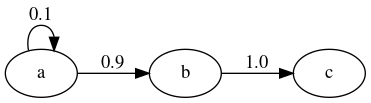

In [210]:
import pygraphviz as pgv
import pandas as pd
from IPython.display import Image

def draw(dot):
    return Image(pgv.AGraph(dot).draw(format='png', prog='dot'))

graph = pd.DataFrame(PTM)

g1 = """digraph top {
   rankdir=LR;
   a -> a [label = 0.1, rankdir=LR];
   a -> b [label = 0.9]
   b -> c [label = 1.0];
}"""
draw(g1)

In [211]:
graph

,0,1,2,3,4,5,6
0,0.95,0.05,0.00,0.00,0.00,0.0,0.0
1,0.10,0.85,0.05,0.00,0.00,0.0,0.0
2,0.00,0.10,0.80,0.10,0.00,0.0,0.0
3,0.00,0.00,0.15,0.70,0.15,0.0,0.0
4,0.00,0.00,0.00,0.15,0.65,0.2,0.0
5,0.00,0.00,0.00,0.00,0.20,0.6,0.2
6,0.00,0.00,0.00,0.00,0.00,0.1,0.9


In [212]:
cols = graph.columns
text = [str(graph.index.values[j]) + '->'+str(i)+'[label='+str(graph.loc[j,i])+']' for i in cols for j in graph.index if graph.loc[j,i] > 0]

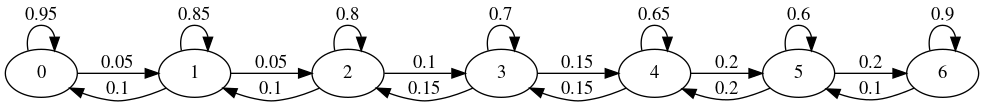

In [213]:
g1='digraph top {rankdir=LR;'+';'.join(text)+'}'
draw(g1)

# Create a sequence / PTM / FTM from customer life cycle -- Need to complete

# Example of Reliance Retail

In [214]:
TPM1 = np.array([
       [0.4351, 0.0032, 0.1316, 0.0147, 0.2225, 0.1308, 0.0621],
       [0.0171, 0.4203, 0.0542, 0.0199, 0.1088, 0.124 , 0.2557],
       [0.0564, 0.0091, 0.5941, 0.0491, 0.1504, 0.0721, 0.0688],
       [0.0149, 0.0085, 0.1634, 0.4034, 0.2185, 0.1314, 0.0599],
       [0.0613, 0.0092, 0.1045, 0.0395, 0.6235, 0.0975, 0.0645],
       [0.0737, 0.0201, 0.0857, 0.0187, 0.1693, 0.5247, 0.1078],
       [0.0553, 0.0638, 0.1401, 0.0323, 0.2424, 0.1739, 0.2922]
])

TPM1

array([[0.4351, 0.0032, 0.1316, 0.0147, 0.2225, 0.1308, 0.0621],
       [0.0171, 0.4203, 0.0542, 0.0199, 0.1088, 0.124 , 0.2557],
       [0.0564, 0.0091, 0.5941, 0.0491, 0.1504, 0.0721, 0.0688],
       [0.0149, 0.0085, 0.1634, 0.4034, 0.2185, 0.1314, 0.0599],
       [0.0613, 0.0092, 0.1045, 0.0395, 0.6235, 0.0975, 0.0645],
       [0.0737, 0.0201, 0.0857, 0.0187, 0.1693, 0.5247, 0.1078],
       [0.0553, 0.0638, 0.1401, 0.0323, 0.2424, 0.1739, 0.2922]])

In [215]:
TPM2 = np.array([
       [0.4218, 0.    , 0.0889, 0.1062, 0.2269, 0.0812, 0.075 ],
       [0.    , 0.5278, 0.1667, 0.    , 0.1667, 0.0833, 0.0555],
       [0.0375, 0.0167, 0.6189, 0.061 , 0.1335, 0.0542, 0.0782],
       [0.0102, 0.007 , 0.1766, 0.4786, 0.2058, 0.0693, 0.0525],
       [0.0501, 0.0216, 0.0671, 0.0719, 0.5913, 0.098 , 0.1   ],
       [0.0737, 0.0052, 0.0764, 0.026 , 0.1977, 0.471 , 0.15  ],
       [0.0734, 0.0515, 0.1549, 0.0367, 0.2169, 0.1684, 0.2982]
]
)

In [216]:
TPM2

array([[0.4218, 0.    , 0.0889, 0.1062, 0.2269, 0.0812, 0.075 ],
       [0.    , 0.5278, 0.1667, 0.    , 0.1667, 0.0833, 0.0555],
       [0.0375, 0.0167, 0.6189, 0.061 , 0.1335, 0.0542, 0.0782],
       [0.0102, 0.007 , 0.1766, 0.4786, 0.2058, 0.0693, 0.0525],
       [0.0501, 0.0216, 0.0671, 0.0719, 0.5913, 0.098 , 0.1   ],
       [0.0737, 0.0052, 0.0764, 0.026 , 0.1977, 0.471 , 0.15  ],
       [0.0734, 0.0515, 0.1549, 0.0367, 0.2169, 0.1684, 0.2982]])

In [217]:
CI = np.array([.0842, .0350, .2085, .0531, .2979, .2332, .0881,])

In [218]:
get_state_after_n_periods(TPM1, 3, CI)

(array([[0.1435889 , 0.01949514, 0.20033002, 0.04297996, 0.31923931,
         0.18077878, 0.09358789],
        [0.06932836, 0.1032959 , 0.15983646, 0.04275374, 0.27128584,
         0.19573755, 0.15776215],
        [0.08570036, 0.02175923, 0.3060971 , 0.05957433, 0.2814319 ,
         0.15126049, 0.09417658],
        [0.07060165, 0.0221903 , 0.21741957, 0.10287314, 0.31382835,
         0.17892247, 0.09416452],
        [0.08945227, 0.02194736, 0.18732669, 0.05346856, 0.38722832,
         0.16683909, 0.09373771],
        [0.095799  , 0.03029607, 0.1751933 , 0.0423752 , 0.29620363,
         0.24923087, 0.11090193],
        [0.08645822, 0.04081447, 0.19658379, 0.04923341, 0.31573316,
         0.19332102, 0.11785594]]),
 array([0.09273928, 0.02817087, 0.21180702, 0.05314675, 0.32396389,
        0.18796457, 0.10220763]))

In [219]:
get_state_after_n_periods(TPM2, 3, CI)

(array([[0.12428562, 0.02152529, 0.1757432 , 0.11719637, 0.31348227,
         0.1362827 , 0.11148455],
        [0.04592742, 0.16622462, 0.22797055, 0.05186535, 0.27084918,
         0.13325328, 0.1039096 ],
        [0.06541128, 0.03207103, 0.32453326, 0.09391688, 0.25769337,
         0.11771667, 0.10865752],
        [0.05361602, 0.02567923, 0.22973676, 0.1670178 , 0.29481269,
         0.1255029 , 0.1036346 ],
        [0.07468071, 0.03537444, 0.1623886 , 0.09791472, 0.36273561,
         0.14705442, 0.11985149],
        [0.08866638, 0.02748347, 0.16547629, 0.07732546, 0.30310558,
         0.20325813, 0.13468468],
        [0.08085851, 0.04562588, 0.20209384, 0.08224334, 0.2999174 ,
         0.16090374, 0.12835729]]),
 array([0.07860559, 0.0366475 , 0.20740986, 0.09458027, 0.31042443,
        0.15272992, 0.11960243]))

In [221]:
get_Steady_State_Probability(TPM2)

array([[0.07611653],
       [0.03763243],
       [0.21203731],
       [0.09874663],
       [0.31036497],
       [0.14727556],
       [0.11782657]])

In [222]:
get_Steady_State_Probability(TPM1)

array([[0.09298825],
       [0.02736447],
       [0.21345419],
       [0.05368479],
       [0.32721808],
       [0.18409738],
       [0.10119285]])

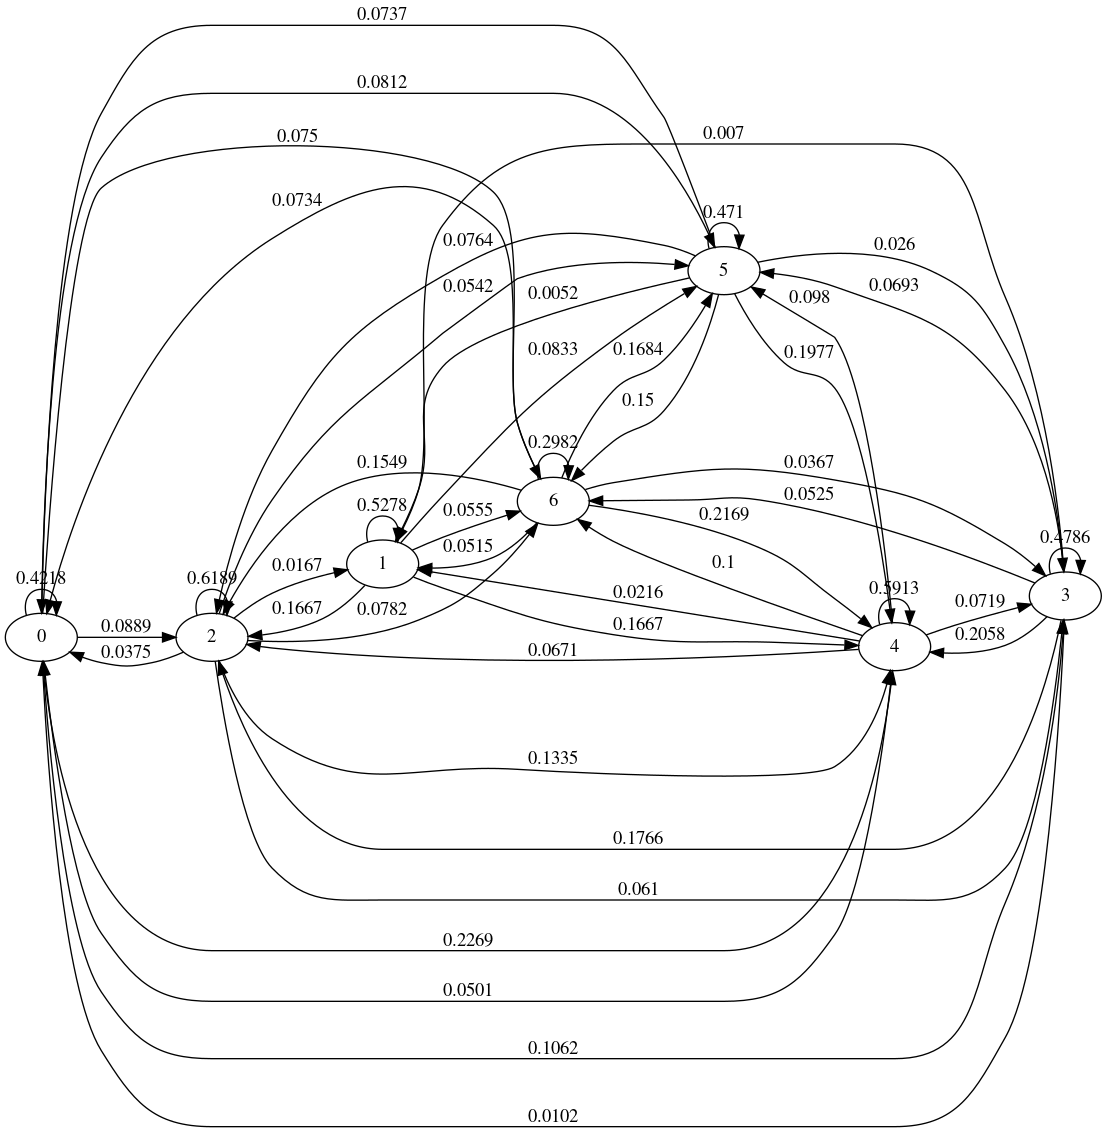

In [223]:
graph = pd.DataFrame(TPM2)

cols = graph.columns
text = [str(graph.index.values[j]) + '->'+str(i)+'[label='+str(graph.loc[j,i])+']' for i in cols for j in graph.index if graph.loc[j,i] > 0]

g1='digraph top {rankdir=LR;'+';'.join(text)+'}'
draw(g1)

# Example - CLV of a particular State / Brand

- Here we make the other states 0 (see margin matrix)

In [224]:
PI = np.array([.0842, .0350, .2085, .0531, .2979, .2332, .0881,])* 800
print(PI)

margin = np.array([0, 0, 0., 165, 0, 0., 0.])
get_clv_after_n_periods(TPM1, 4, PI, margin, 0.9999)

[ 67.36  28.   166.8   42.48 238.32 186.56  70.48]


34974.978490643465

In [225]:
PI = np.array([.0684, .0342, .2279, 0.0627, .3390, .1823, .0855,])* 800
margin = np.array([0, 0, 0., 168.3, 0, 0., 0.])


get_clv_after_n_periods(TPM2, 4, PI, margin, 0.9999)

58142.03020301752